<a href="https://colab.research.google.com/github/rk2026/GEOG-510/blob/main/AUSTRALIA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary library (Do we need all the library listed below? can we minimize it? Do research?)

In [10]:
import os
from google.colab import drive
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from itertools import product
from google.colab import data_table
import math
from google.colab import files
data_table.enable_dataframe_formatter()

In case, we load necessary data from google drive so we need provide to acess our drive.

In [11]:
#drive.mount('/content/drive')

Now we already created a folder within google drive namely 'MTanalysis'. This folder contains the data we need to process

In [12]:
#data_folder = os.path.join('drive', 'My Drive', 'MTanalysis')

Read the shapefile that is the boundary of community forests from google drive's folder named **`MTanalysis`**

In [13]:
#cfouter_shp = gpd.read_file(os.path.join(data_folder, 'cfouter.shp'))

Read the CSV file. This file contains stem mapping data for each tree within the extent.

In [14]:
#treeloc_csv = pd.read_csv(os.path.join(data_folder, 'TreeLoc.csv'))
#sppVal = pd.read_csv(os.path.join(data_folder, 'sppVal.csv'))

Read the CSV file into a Pandas DataFrame

In [15]:
#df = pd.read_csv("/content/drive/MyDrive/MTanalysis/TreeLoc.csv")

Upload csv files from local computer.It will tree location data.

In [16]:
stemmapping = files.upload()

Saving TreeLoc.csv to TreeLoc.csv


In [42]:
df = pd.read_csv('TreeLoc.csv')

upload csv file containing species value a, b,c,a1,b1, c1, b, g, bg

In [18]:
sppVal = files.upload()

Saving sppVal.csv to sppVal.csv


In [19]:
sppVal = pd.read_csv('sppVal.csv')

upload ESRI shape file(The outer boundary of stemmapping area).

In [20]:
cfouter_shp = files.upload()

Saving cfouter.zip to cfouter (2).zip


plot shape file

In [21]:
data = gpd.read_file('zip://cfouter.zip!/cfouter.shp')

Create a GeoDataFrame with the X and Y columns as geometry

In [22]:
# pylint:disable
geometry = gpd.points_from_xy(df["X"], df["Y"])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

Create fishnet and findout the centroid of the fishnet polygon

In [23]:
from google.colab import drive
drive.mount('/content/drive')

mtanalysis_path = '/content/drive/My Drive/MTanalysis'

import sys
sys.path.append(mtanalysis_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


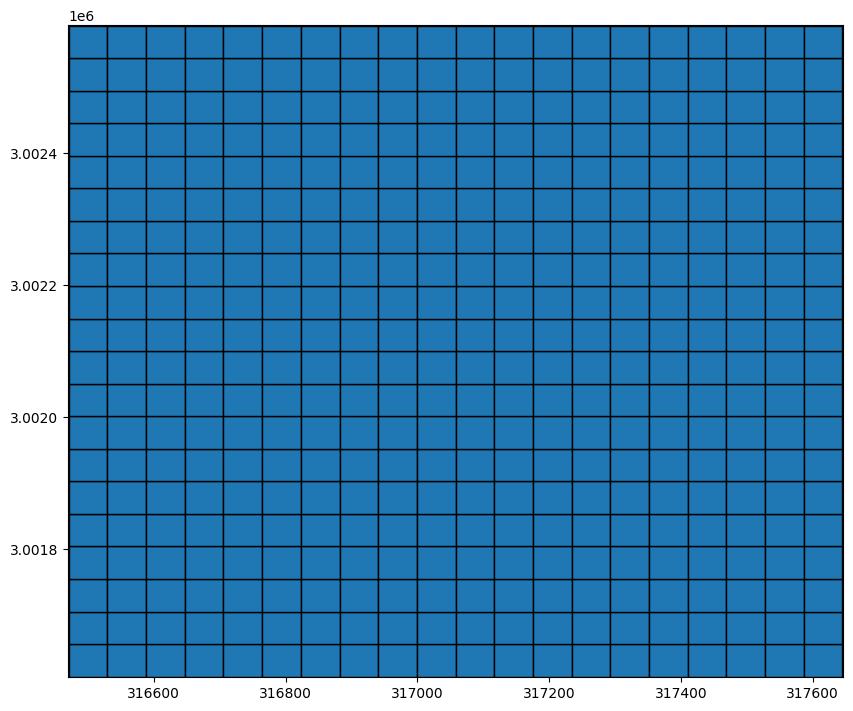

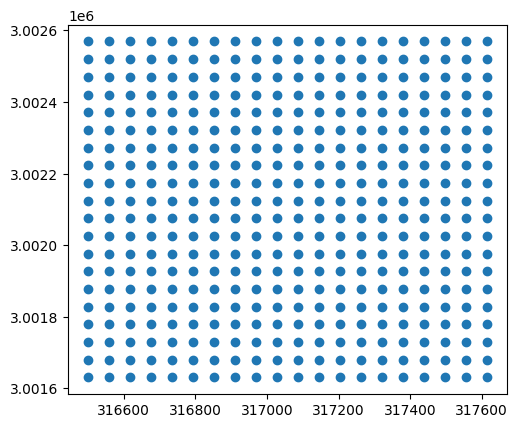

In [43]:
from utils import create_grid
grid,centroid_gdf=create_grid(gdf)

The centroid is in geoseries format. We need to convert it in geopandas dataframe format.

Spatial join based on closest.

In [25]:
joined = gpd.sjoin_nearest(centroid_gdf,gdf, how="right", distance_col="distance")

<ipython-input-25-62af01169af1>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32645
Right CRS: None

  joined = gpd.sjoin_nearest(centroid_gdf,gdf, how="right", distance_col="distance")


Export shape file to drive

In [26]:
Joined_sorted = joined.sort_values(by=['index_left', 'class'], ascending=True)

:# Group the GeoDataFrame by the 'right_index' column

In [27]:
grouped_gdf = Joined_sorted.groupby('index_left')

In [28]:
first_unique_rows = grouped_gdf.head(1)

In [29]:
mt=first_unique_rows.copy()

In [30]:
# Create a copy of Joined_sorted
df_with_remarks = Joined_sorted.copy()

# Add a new column named 'Remarks'
df_with_remarks['status'] = ''

# Find the indices of TreeIDs that are in the 'mt' variable
mt_indices = df_with_remarks.index[df_with_remarks['TID'].isin(mt['TID'])]

# Update the 'Remarks' column for those indices with 'mt'
df_with_remarks.loc[mt_indices, 'status'] = 'Mother Tree'

# Print the updated DataFrame
df_with_remarks

,index_left,TID,species,X,Y,dia_cm,height_m,class,geometry,distance,status
13463,3,13468,Dalbergia sissoo,316524,3001801,67,17,1,POINT (316524 3001801),32.368696,Mother Tree
19248,3,19253,Tsuga spp,316529,3001779,39,21,1,POINT (316529 3001779),28.650175,
422,3,427,Shorea robusta,316527,3001775,60,25,2,POINT (316527 3001775),26.933854,
22304,3,22309,Shorea robusta,316529,3001801,96,17,3,POINT (316529 3001801),36.183318,
23599,3,23604,Acacia catechu,316528,3001760,81,16,4,POINT (316528 3001760),33.492275,
...,...,...,...,...,...,...,...,...,...,...,...
26961,388,26966,Anogeissus latifolia,317594,3002013,34,28,3,POINT (317594 3002013),25.201835,
3383,388,3388,Adino cordifolia,317597,3002002,87,23,4,POINT (317597 3002002),30.315549,
3741,388,3746,Quercus spp,317589,3002007,62,19,4,POINT (317589 3002007),32.671586,
10515,388,10520,Alnus nepalensis,317589,3002025,42,17,4,POINT (317589 3002025),26.665193,


In [31]:
# Join the GeoDataFrames based on the 'species' column
merged_gdf = df_with_remarks.merge(sppVal, left_on='species', right_on='Scientific Name')

In [32]:
merged_df = pd.merge(df_with_remarks, sppVal, left_on='species', right_on='Scientific Name')

stem volume calculation formula
v = EXP(a + b * ln(dia_cm) + c *ln(height_m))

In [33]:
merged_gdf['stem_volume'] = merged_gdf.apply(lambda row: math.exp(row['a'] + row['b'] * math.log(row['dia_cm']) + row['c'] * math.log(row['height_m'])), axis=1)/1000

In [34]:
# merged_gdf.to_csv("/content/drive/MyDrive/MTanalysis/Hello.csv")

In [35]:
def calculate_branch_ratio(row):
    if row['dia_cm'] < 10:
        return row['s']
    elif 10 <= row['dia_cm'] < 40:
        return ((row['dia_cm'] - 10) * row['m'] + (40 - row['dia_cm']) * row['s']) / 30
    elif 40 <= row['dia_cm'] < 70:
        return ((row['dia_cm'] - 10) * row['m'] + (40 - row['dia_cm']) * row['s']) / 30
    else:
        return row['b']

merged_gdf['branch_ratio'] = merged_gdf.apply(calculate_branch_ratio, axis=1)
merged_gdf.sort_values(by='TID')

,index_left,TID,species,X,Y,dia_cm,height_m,class,geometry,distance,...,b,c,a1,b1,s,m,bg,Local Name,stem_volume,branch_ratio
3513,338,1,Shorea robusta,317432,3002539,60,25,2,POINT (317432 3002539),20.538074,...,1.9026,0.8352,5.2026,-2.4788,0.055,0.341,0.357,Sal,3.050025,0.531667
2476,32,2,Shorea robusta,316530,3002219,60,25,2,POINT (316530 3002219),29.396471,...,1.9026,0.8352,5.2026,-2.4788,0.055,0.341,0.357,Sal,3.050025,0.531667
2775,113,3,Shorea robusta,316810,3002295,60,25,2,POINT (316810 3002295),27.372112,...,1.9026,0.8352,5.2026,-2.4788,0.055,0.341,0.357,Sal,3.050025,0.531667
3134,223,4,Shorea robusta,317131,3001778,60,25,2,POINT (317131 3001778),15.076886,...,1.9026,0.8352,5.2026,-2.4788,0.055,0.341,0.357,Sal,3.050025,0.531667
20959,167,5,Alnus nepalensis,316963,3001986,104,21,2,POINT (316963 3001986),11.770833,...,1.9006,0.9428,6.0190,-2.7271,0.803,1.226,1.510,Uttis,7.490607,1.900600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7741,161,27596,Pinus wallichiana,316980,3001704,81,22,3,POINT (316980 3001704),25.927061,...,1.7250,1.1623,5.7216,-2.6788,0.683,0.488,0.410,Gobre Salla,4.245621,1.725000
20133,285,27597,Quercus spp,317333,3001874,51,28,2,POINT (317333 3001874),11.463529,...,1.9680,0.7496,4.8511,-2.4494,0.747,0.960,1.060,Kharsu,2.632406,1.038100
11450,198,27598,Schima wallichii,317010,3002504,96,18,3,POINT (317010 3002504),24.507805,...,1.8155,1.0072,7.4617,-3.0676,0.520,0.186,0.168,Chilaune,4.718549,1.815500
3592,370,27599,Shorea robusta,317532,3002136,60,25,2,POINT (317532 3002136),27.389642,...,1.9026,0.8352,5.2026,-2.4788,0.055,0.341,0.357,Sal,3.050025,0.531667


Calculate Branch volume, tree volume, 10 cm top dia ratio etc

In [36]:
merged_gdf['branch_volume'] = merged_gdf['stem_volume'] * merged_gdf['branch_ratio']
merged_gdf['tree_volume'] = merged_gdf['stem_volume'] + merged_gdf['branch_volume']
merged_gdf['cm10diaratio'] = merged_gdf['stem_volume'] + merged_gdf['branch_volume']
merged_gdf['cm10topvolume'] = gpd.np.exp(merged_gdf['a1'] + merged_gdf['b1'] * gpd.np.log(merged_gdf['dia_cm']))
merged_gdf['gross_volume'] = merged_gdf['stem_volume'] - merged_gdf['cm10topvolume']

calculating net volume using function

In [37]:
def calculate_net_volume(row):
  if row['class'] == 1:
    return row['gross_volume'] * 0.8
  elif row['class'] == 2:
    return row['gross_volume'] * 0.6
  elif row['class'] == 3:
    return row['gross_volume'] * 0.3
  else:
    return row['gross_volume'] * 0.

# Apply the function to each row in the GeoDataFrame
merged_gdf['net_volume'] = merged_gdf.apply(calculate_net_volume, axis=1)

In [38]:
# Create a new column called 'net_volum_cft'
merged_gdf['net_volum_cft'] = None

# Apply a lambda function to each row to calculate the new column value
merged_gdf['net_volum_cft'] = merged_gdf.apply(lambda row: row['net_volume'] * 3.28*3.28*3.28, axis=1)


In [39]:
# Create a new column called 'net_volum_cft'
merged_gdf['firewood_m3'] = None

# Apply a lambda function to each row to calculate the new column value
merged_gdf['firewood_m3'] = merged_gdf.apply(lambda row: row['tree_volume'] - row['net_volume'], axis=1)


In [40]:
# Create a new column called 'net_volum_cft'
merged_gdf['firewood_chatta'] = None

# Apply a lambda function to each row to calculate the new column value
merged_gdf['firewood_chatta'] = merged_gdf.apply(lambda row: row['firewood_m3'] - 0.105944, axis=1)

In [41]:

merged_gdf.sort_values(by='TID')

,index_left,TID,species,X,Y,dia_cm,height_m,class,geometry,distance,...,branch_ratio,branch_volume,tree_volume,cm10diaratio,cm10topvolume,gross_volume,net_volume,net_volum_cft,firewood_m3,firewood_chatta
3513,338,1,Shorea robusta,317432,3002539,60,25,2,POINT (317432 3002539),20.538074,...,0.531667,1.621597,4.671622,4.671622,0.007109,3.042916,1.825750,64.426243,2.845872,2.739928
2476,32,2,Shorea robusta,316530,3002219,60,25,2,POINT (316530 3002219),29.396471,...,0.531667,1.621597,4.671622,4.671622,0.007109,3.042916,1.825750,64.426243,2.845872,2.739928
2775,113,3,Shorea robusta,316810,3002295,60,25,2,POINT (316810 3002295),27.372112,...,0.531667,1.621597,4.671622,4.671622,0.007109,3.042916,1.825750,64.426243,2.845872,2.739928
3134,223,4,Shorea robusta,317131,3001778,60,25,2,POINT (317131 3001778),15.076886,...,0.531667,1.621597,4.671622,4.671622,0.007109,3.042916,1.825750,64.426243,2.845872,2.739928
20959,167,5,Alnus nepalensis,316963,3001986,104,21,2,POINT (316963 3001986),11.770833,...,1.900600,14.236647,21.727254,21.727254,0.001298,7.489309,4.493585,158.567620,17.233669,17.127725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7741,161,27596,Pinus wallichiana,316980,3001704,81,22,3,POINT (316980 3001704),25.927061,...,1.725000,7.323697,11.569318,11.569318,0.002357,4.243264,1.272979,44.920319,10.296339,10.190395
20133,285,27597,Quercus spp,317333,3001874,51,28,2,POINT (317333 3001874),11.463529,...,1.038100,2.732700,5.365106,5.365106,0.008400,2.624005,1.574403,55.556837,3.790702,3.684758
11450,198,27598,Schima wallichii,317010,3002504,96,18,3,POINT (317010 3002504),24.507805,...,1.815500,8.566525,13.285074,13.285074,0.001445,4.717104,1.415131,49.936518,11.869943,11.763999
3592,370,27599,Shorea robusta,317532,3002136,60,25,2,POINT (317532 3002136),27.389642,...,0.531667,1.621597,4.671622,4.671622,0.007109,3.042916,1.825750,64.426243,2.845872,2.739928
